# **Brain Tumor Classification and Segmentation with DINOv2: Fine-Tuning Unsupervised Feature Extractor on MRI Scans**
Hod Fluger, Deep Learning Course, TAU 2025

### 1. Paths & Colab Configuration & Imports

In [ ]:
import os
import sys
from pathlib import Path
import torch
!pip install pydensecrf2

if 'google.colab' in sys.modules:

  print("Running in Google Colab")

  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  relative_dir = "/MyDrive/deep_learning/project_307868596" #CHANGE FOLDER NAME
  project_dir = Path('/content/drive' + relative_dir)

else:

  print("Not running in Google Colab")
  project_dir = Path(os.getcwd())

os.chdir(project_dir)
print(f"running in '{project_dir}'")

# define data dir and models dir
data_dir = project_dir.joinpath("MRI_data").joinpath("splited")

print(f"Data Dir: '{data_dir}'")
models_dir = project_dir.joinpath("saved_models")
print(f"Saved Models Dir: '{models_dir}'")

if torch.cuda.is_available():

  print('GPU is available.')
  torch.device('cuda')
else:
  print('GPU is NOT available. Using CPU.')

from models.models import DinoV2MRISeg, DinoV2MRIClass
from datasets.datasets import MRIDatasetSeg, MRIDatasetClass, create_seg_transforms, create_class_transforms, arrange_data, arrange_aplited_data
from train_utils.train_utils import FocalLoss, CombinedLoss, train_model, parse_model_name, plot_convergence_graph, evaluate_trained_model,show_segmentations, CLASS, SEG
import torch.nn as nn
import numpy as np
import random

Running in Google Colab
Mounted at /content/drive
running in '/content/drive/MyDrive/deep_learning/project'
Data Dir: '/content/drive/MyDrive/deep_learning/project/MRI_data/splited'
Saved Models Dir: '/content/drive/MyDrive/deep_learning/project/saved_models'
GPU is available.


### 2. Classification - Train

In [ ]:
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

crop = False #True if we want to use “Tumor Cropped” images
batch_sizes = [16]
scales = [(1.0, 1.0)] # Random scaling as augmentation: (min scale, max scale). (1,0, 1,0) means no scaling.
learning_rates = ['5e-4']
loss_funcs = ['CE'] # for example: ['CE', 'Focaloss1', 'Focaloss2'] The number mentioned in Focaloss_ is gamma value
dino_size = 'base'
num_epochs = 100

if crop:
  image_dir = data_dir.joinpath("croped_images")
  crop_str = 'Croped'
else:
  image_dir = data_dir.joinpath("images")
  crop_str = ''


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for scale in scales:
  train_transform, test_transform = create_class_transforms(h_flip=0.5, translate=(0., 0.), scale=scale)
  for lr_str in learning_rates:
    lr = float(lr_str)
    for batch_size in batch_sizes:
      for loss in loss_funcs:
        if loss == 'CE':
          criterion = nn.CrossEntropyLoss()
        elif loss.startswith('Focaloss'):
          gamma = int(loss[-1])
          criterion = FocalLoss(gamma=gamma)

        model_name = f'seed{seed}_{crop_str}Dino_{dino_size}_bs{batch_size}_lr{lr_str}_{loss}_scale{int(10*scale[0])}-{int(10*scale[1])}_val'
        print(model_name)

        train_loader, val_loader, test_loader = arrange_aplited_data(CLASS, image_dir, None, train_transform, test_transform, batch_size)

        model = DinoV2MRIClass(linear_channels=[3], use_hub=False, size=dino_size)

        val_acc, test_acc = train_model(CLASS, model, criterion, train_loader, val_loader, test_loader, device, epochs=num_epochs, lr=lr,  models_dir=models_dir, title=model_name, improv_cnt_th=10, save_score_th=0.9)
        print('--------------------------------------------------------------')
        print('--------------------------------------------------------------')

seed100_Dino_base_bs16_lr5e-4_CE_scale10-10_val


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/58.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/353M [00:00<?, ?B/s]

ModuleList(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=768, out_features=3, bias=True)
)


Epoch 1/100:   0%|          | 0/134 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Validation: 100%|██████████| 29/29 [08:21<00:00, 17.28s/it]


Epoch [1/100], Train Loss: 0.9554, Train Accuracy: 0.5933, Val Loss: 0.6128, Val Accuracy: 0.7277
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]


Epoch [2/100], Train Loss: 0.5968, Train Accuracy: 0.7458, Val Loss: 0.4537, Val Accuracy: 0.8257
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


Epoch [3/100], Train Loss: 0.5032, Train Accuracy: 0.7934, Val Loss: 0.4153, Val Accuracy: 0.8192
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


Epoch [4/100], Train Loss: 0.4415, Train Accuracy: 0.8162, Val Loss: 0.3821, Val Accuracy: 0.8715
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch [5/100], Train Loss: 0.3944, Train Accuracy: 0.8302, Val Loss: 0.3361, Val Accuracy: 0.8671
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch [6/100], Train Loss: 0.3937, Train Accuracy: 0.8456, Val Loss: 0.3247, Val Accuracy: 0.8867
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]


Epoch [7/100], Train Loss: 0.3663, Train Accuracy: 0.8479, Val Loss: 0.3118, Val Accuracy: 0.8845
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [8/100], Train Loss: 0.3515, Train Accuracy: 0.8577, Val Loss: 0.3043, Val Accuracy: 0.8780
No improvement for 2 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch [9/100], Train Loss: 0.3376, Train Accuracy: 0.8666, Val Loss: 0.2857, Val Accuracy: 0.9020
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.23it/s]


Epoch [10/100], Train Loss: 0.3261, Train Accuracy: 0.8689, Val Loss: 0.2755, Val Accuracy: 0.9020
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [11/100], Train Loss: 0.3072, Train Accuracy: 0.8839, Val Loss: 0.2706, Val Accuracy: 0.8976
No improvement for 2 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [12/100], Train Loss: 0.3037, Train Accuracy: 0.8783, Val Loss: 0.2683, Val Accuracy: 0.9020
No improvement for 3 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [13/100], Train Loss: 0.3000, Train Accuracy: 0.8811, Val Loss: 0.2646, Val Accuracy: 0.9085
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch [14/100], Train Loss: 0.2976, Train Accuracy: 0.8825, Val Loss: 0.2548, Val Accuracy: 0.9085
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [15/100], Train Loss: 0.2784, Train Accuracy: 0.8857, Val Loss: 0.2562, Val Accuracy: 0.9107
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [16/100], Train Loss: 0.2823, Train Accuracy: 0.8876, Val Loss: 0.2491, Val Accuracy: 0.9063
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch [17/100], Train Loss: 0.2737, Train Accuracy: 0.8853, Val Loss: 0.2429, Val Accuracy: 0.9063
No improvement for 2 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch [18/100], Train Loss: 0.2749, Train Accuracy: 0.8927, Val Loss: 0.2546, Val Accuracy: 0.9172
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [19/100], Train Loss: 0.2624, Train Accuracy: 0.8974, Val Loss: 0.2454, Val Accuracy: 0.9129
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


Epoch [20/100], Train Loss: 0.2650, Train Accuracy: 0.8927, Val Loss: 0.2394, Val Accuracy: 0.9194
Saving Best Model...


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch [21/100], Train Loss: 0.2628, Train Accuracy: 0.8913, Val Loss: 0.2407, Val Accuracy: 0.9085
No improvement for 1 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


Epoch [22/100], Train Loss: 0.2446, Train Accuracy: 0.9049, Val Loss: 0.2320, Val Accuracy: 0.9063
No improvement for 2 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch [23/100], Train Loss: 0.2569, Train Accuracy: 0.9053, Val Loss: 0.2433, Val Accuracy: 0.8998
No improvement for 3 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [24/100], Train Loss: 0.2443, Train Accuracy: 0.9049, Val Loss: 0.2362, Val Accuracy: 0.9063
No improvement for 4 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch [25/100], Train Loss: 0.2499, Train Accuracy: 0.8983, Val Loss: 0.2518, Val Accuracy: 0.8976
No improvement for 5 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch [26/100], Train Loss: 0.2492, Train Accuracy: 0.9007, Val Loss: 0.2282, Val Accuracy: 0.9150
No improvement for 6 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch [27/100], Train Loss: 0.2424, Train Accuracy: 0.8983, Val Loss: 0.2416, Val Accuracy: 0.9063
No improvement for 7 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Epoch [28/100], Train Loss: 0.2447, Train Accuracy: 0.9044, Val Loss: 0.2253, Val Accuracy: 0.9129
No improvement for 8 epochs.


Validation: 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch [29/100], Train Loss: 0.2382, Train Accuracy: 0.9058, Val Loss: 0.2210, Val Accuracy: 0.9172
No improvement for 9 epochs.


Validation: 100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


Epoch [30/100], Train Loss: 0.2387, Train Accuracy: 0.9053, Val Loss: 0.2244, Val Accuracy: 0.9063
No improvement for 10 epochs.
Saving Best Model...


Validation: 100%|██████████| 29/29 [09:05<00:00, 18.81s/it]

Model Accuracy: Val: 0.9193899782135077, Test 0.8915401301518439
--------------------------------------------------------------
--------------------------------------------------------------


### 3. Semantic Segmentation - Train


In [ ]:
seed = 150
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


normalizations = [{"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225], "name": 'ImageNet'}]  #also possible: {"mean": [0.5, 0.5, 0.5], "std": [0.5, 0.5, 0.5], "name": '05'}
batch_sizes = [20]
learning_rates = ['3e-4']
loss_funcs = ['Combined5'] #['CE', 'Combined2']  The number in "Combined_" is the alpha value, as described in the report.
num_epochs = 100

image_dir = data_dir.joinpath("images")
mask_dir = data_dir.joinpath("masks")
dino_size = 'base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for norm in normalizations:
  img_transform, mask_transform = create_seg_transforms(mean=norm["mean"], std=norm["std"])
  for lr_str in learning_rates:
    lr = float(lr_str)
    for batch_size in batch_sizes:
      train_loader, val_loader, test_loader = arrange_aplited_data(SEG, image_dir, mask_dir, img_transform, mask_transform, batch_size, random_crop=50)
      for loss in loss_funcs:
        if loss == 'CE':
          #class_weights = torch.tensor([1.03, 33.3]).to(device)  # Adjust based on dataset imbalance
          #criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
          criterion = torch.nn.CrossEntropyLoss()
        elif loss.startswith('Combined'):
          criterion = CombinedLoss(ce_weight=1.0-float(loss[-1]) / 10)


        model_name = f'seed{seed}_DinoSeg_{dino_size}_bs{batch_size}_lr{lr_str}_{loss}_norm{norm["name"]}_RandomCrop50_val'
        print(model_name)

        id2label = {0: "background", 1: "tumor"}
        model = DinoV2MRISeg.from_pretrained(f'facebook/dinov2-{dino_size}', id2label=id2label,
                                                            num_labels=len(id2label))

        val_iou, test_iou = train_model(SEG, model, criterion, train_loader, val_loader, test_loader, device, epochs=num_epochs, lr=lr,  models_dir=models_dir, title=model_name, improv_cnt_th=10, save_score_th=0.4)
        print('--------------------------------------------------------------')
        print('--------------------------------------------------------------')

seed150_DinoSeg_base_bs20_lr3e-4_Combined5_normImageNet_RandomCrop50_val


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of DinoV2MRISeg were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 23/23 [09:05<00:00, 23.72s/it]


Epoch [1/100], Train Loss: 0.5143, Train mIoU: 0.2320, Val Loss: 0.3910, Val mIoU: 0.3063
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [2/100], Train Loss: 0.4378, Train mIoU: 0.3046, Val Loss: 0.3649, Val mIoU: 0.3383
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Epoch [3/100], Train Loss: 0.4206, Train mIoU: 0.3319, Val Loss: 0.3465, Val mIoU: 0.3556
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [4/100], Train Loss: 0.4103, Train mIoU: 0.3367, Val Loss: 0.3320, Val mIoU: 0.3732
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [5/100], Train Loss: 0.4018, Train mIoU: 0.3493, Val Loss: 0.3342, Val mIoU: 0.3730
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Epoch [6/100], Train Loss: 0.4058, Train mIoU: 0.3485, Val Loss: 0.3268, Val mIoU: 0.3810
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [7/100], Train Loss: 0.3958, Train mIoU: 0.3536, Val Loss: 0.3216, Val mIoU: 0.3877
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Epoch [8/100], Train Loss: 0.3955, Train mIoU: 0.3612, Val Loss: 0.3206, Val mIoU: 0.3886
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [9/100], Train Loss: 0.3894, Train mIoU: 0.3620, Val Loss: 0.3103, Val mIoU: 0.3994
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [10/100], Train Loss: 0.3901, Train mIoU: 0.3574, Val Loss: 0.3099, Val mIoU: 0.4049
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Epoch [11/100], Train Loss: 0.3908, Train mIoU: 0.3605, Val Loss: 0.3056, Val mIoU: 0.4076
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Epoch [12/100], Train Loss: 0.3902, Train mIoU: 0.3717, Val Loss: 0.3191, Val mIoU: 0.3974
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [13/100], Train Loss: 0.3889, Train mIoU: 0.3579, Val Loss: 0.3083, Val mIoU: 0.4070
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [14/100], Train Loss: 0.3903, Train mIoU: 0.3685, Val Loss: 0.3126, Val mIoU: 0.4027
No improvement for 3 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [15/100], Train Loss: 0.3896, Train mIoU: 0.3567, Val Loss: 0.3070, Val mIoU: 0.4081
Saving Best Model...


100%|██████████| 23/23 [00:16<00:00,  1.44it/s]


Epoch [16/100], Train Loss: 0.3849, Train mIoU: 0.3716, Val Loss: 0.3110, Val mIoU: 0.4068
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [17/100], Train Loss: 0.3823, Train mIoU: 0.3671, Val Loss: 0.3096, Val mIoU: 0.4116
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [18/100], Train Loss: 0.3813, Train mIoU: 0.3713, Val Loss: 0.2999, Val mIoU: 0.4207
Saving Best Model...


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


Epoch [19/100], Train Loss: 0.3833, Train mIoU: 0.3741, Val Loss: 0.2973, Val mIoU: 0.4219
Saving Best Model...


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


Epoch [20/100], Train Loss: 0.3852, Train mIoU: 0.3651, Val Loss: 0.2972, Val mIoU: 0.4234
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [21/100], Train Loss: 0.3814, Train mIoU: 0.3825, Val Loss: 0.3059, Val mIoU: 0.4182
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [22/100], Train Loss: 0.3802, Train mIoU: 0.3727, Val Loss: 0.2940, Val mIoU: 0.4275
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


Epoch [23/100], Train Loss: 0.3805, Train mIoU: 0.3782, Val Loss: 0.2992, Val mIoU: 0.4235
No improvement for 1 epochs.


100%|██████████| 23/23 [00:16<00:00,  1.43it/s]


Epoch [24/100], Train Loss: 0.3820, Train mIoU: 0.3711, Val Loss: 0.2955, Val mIoU: 0.4261
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [25/100], Train Loss: 0.3842, Train mIoU: 0.3747, Val Loss: 0.2905, Val mIoU: 0.4299
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [26/100], Train Loss: 0.3852, Train mIoU: 0.3745, Val Loss: 0.2968, Val mIoU: 0.4269
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [27/100], Train Loss: 0.3818, Train mIoU: 0.3704, Val Loss: 0.2990, Val mIoU: 0.4240
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.44it/s]


Epoch [28/100], Train Loss: 0.3816, Train mIoU: 0.3794, Val Loss: 0.2897, Val mIoU: 0.4328
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.44it/s]


Epoch [29/100], Train Loss: 0.3762, Train mIoU: 0.3779, Val Loss: 0.2889, Val mIoU: 0.4316
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.45it/s]


Epoch [30/100], Train Loss: 0.3786, Train mIoU: 0.3778, Val Loss: 0.2922, Val mIoU: 0.4306
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [31/100], Train Loss: 0.3800, Train mIoU: 0.3668, Val Loss: 0.2951, Val mIoU: 0.4270
No improvement for 3 epochs.


100%|██████████| 23/23 [00:16<00:00,  1.42it/s]


Epoch [32/100], Train Loss: 0.3837, Train mIoU: 0.3667, Val Loss: 0.3032, Val mIoU: 0.4206
No improvement for 4 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [33/100], Train Loss: 0.3776, Train mIoU: 0.3749, Val Loss: 0.2918, Val mIoU: 0.4337
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [34/100], Train Loss: 0.3790, Train mIoU: 0.3741, Val Loss: 0.3003, Val mIoU: 0.4241
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [35/100], Train Loss: 0.3776, Train mIoU: 0.3834, Val Loss: 0.2921, Val mIoU: 0.4320
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [36/100], Train Loss: 0.3707, Train mIoU: 0.3735, Val Loss: 0.3071, Val mIoU: 0.4140
No improvement for 3 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [37/100], Train Loss: 0.3840, Train mIoU: 0.3782, Val Loss: 0.2890, Val mIoU: 0.4364
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [38/100], Train Loss: 0.3820, Train mIoU: 0.3807, Val Loss: 0.2854, Val mIoU: 0.4357
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.53it/s]


Epoch [39/100], Train Loss: 0.3791, Train mIoU: 0.3811, Val Loss: 0.2980, Val mIoU: 0.4273
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [40/100], Train Loss: 0.3766, Train mIoU: 0.3742, Val Loss: 0.2945, Val mIoU: 0.4309
No improvement for 3 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


Epoch [41/100], Train Loss: 0.3767, Train mIoU: 0.3892, Val Loss: 0.2811, Val mIoU: 0.4412
Saving Best Model...


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [42/100], Train Loss: 0.3757, Train mIoU: 0.3751, Val Loss: 0.2858, Val mIoU: 0.4387
No improvement for 1 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.46it/s]


Epoch [43/100], Train Loss: 0.3719, Train mIoU: 0.3921, Val Loss: 0.3004, Val mIoU: 0.4254
No improvement for 2 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Epoch [44/100], Train Loss: 0.3777, Train mIoU: 0.3752, Val Loss: 0.2854, Val mIoU: 0.4376
No improvement for 3 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [45/100], Train Loss: 0.3736, Train mIoU: 0.3817, Val Loss: 0.2804, Val mIoU: 0.4405
No improvement for 4 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.52it/s]


Epoch [46/100], Train Loss: 0.3832, Train mIoU: 0.3720, Val Loss: 0.2833, Val mIoU: 0.4408
No improvement for 5 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.44it/s]


Epoch [47/100], Train Loss: 0.3777, Train mIoU: 0.3851, Val Loss: 0.2869, Val mIoU: 0.4384
No improvement for 6 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Epoch [48/100], Train Loss: 0.3756, Train mIoU: 0.3789, Val Loss: 0.2878, Val mIoU: 0.4375
No improvement for 7 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.48it/s]


Epoch [49/100], Train Loss: 0.3756, Train mIoU: 0.3817, Val Loss: 0.2820, Val mIoU: 0.4410
No improvement for 8 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


Epoch [50/100], Train Loss: 0.3786, Train mIoU: 0.3755, Val Loss: 0.2914, Val mIoU: 0.4340
No improvement for 9 epochs.


100%|██████████| 23/23 [00:15<00:00,  1.49it/s]


Epoch [51/100], Train Loss: 0.3721, Train mIoU: 0.3881, Val Loss: 0.2859, Val mIoU: 0.4395
No improvement for 10 epochs.
Saving Best Model...


 96%|█████████▌| 23/24 [08:56<00:23, 23.33s/it]


ValueError: Expected input batch_size (2) to match target batch_size (224).

### 4. Classification - Evaluation

ModuleList(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=768, out_features=3, bias=True)
)


Validation: 100%|██████████| 29/29 [00:20<00:00,  1.43it/s]

Accuracy: 0.9371


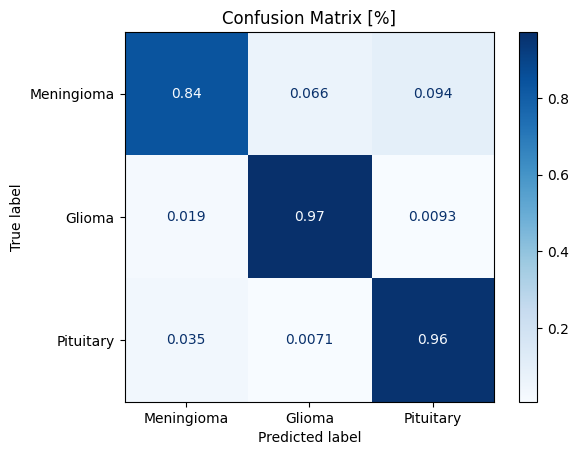

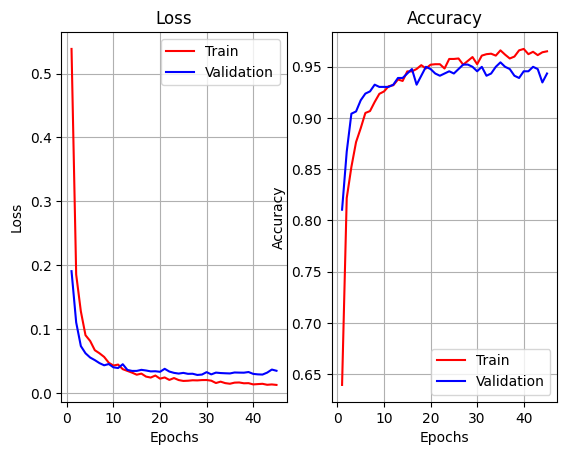

In [ ]:
    model_name = 'seed100_CropedDino_base_bs16_lr5e-4_Focaloss1_scale10-10_val_Accuracy95_4.pt'
    seed, dino_size, batch_size, crop = parse_model_name(model_name)
    train_transform, test_transform = create_class_transforms(h_flip=0.5, translate=(0., 0.), scale=(1.0, 1.0))

    if crop:
      image_dir = data_dir.joinpath("croped_images")
    else:
      image_dir = data_dir.joinpath("images")

    train_loader, val_loader, test_loader = arrange_aplited_data(CLASS, image_dir, None, train_transform, test_transform, batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DinoV2MRIClass(linear_channels=[3], use_hub=False, size=dino_size).to(device)
    model_path = models_dir.joinpath(model_name)
    evaluate_trained_model(model, model_path, test_loader, device, plot_confusion_matrix=True)
    json_path = model_name.replace('.pt', '.json')
    plot_convergence_graph(CLASS,  models_dir.joinpath(json_path))

### 5. Semantic Segmentation - Evaluation

In [ ]:
weights_path = 'seed100_DinoSeg_base_bs16_lr5e-4_Combined5_normImageNet_val_mIoU48_8.pt'
detection_th = 0.17

model_path = models_dir.joinpath(weights_path)
_, dino_size, batch_size, _ = parse_model_name(weights_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

id2label = {0: "background", 1: "tumor"}
model = DinoV2MRISeg.from_pretrained(f'facebook/dinov2-{dino_size}', id2label=id2label,
                                      num_labels=len(id2label)).to(device)
weights = torch.load(model_path, weights_only=True, map_location=device)
model.load_state_dict(weights)
model.eval()

if weights_path.__contains__('normImageNet'):
    img_transform, mask_transform = create_seg_transforms(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
else:
    img_transform, mask_transform = create_seg_transforms(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

image_dir = data_dir.joinpath("images")
mask_dir = data_dir.joinpath("masks")
train_loader, val_loader, test_loader = arrange_aplited_data(SEG, image_dir, mask_dir, img_transform,
                                                              mask_transform, batch_size=batch_size)

crf_apperance_kernel = [5, 10, 100]
crf_patial_kernel = [3, 20]
show_segmentations(model,batch_size, val_loader, device, crf_patial_kernel, crf_apperance_kernel, plot=True, print_res=True, th=detection_th)


Output hidden; open in https://colab.research.google.com to view.